In [1]:
% pylab inline
figsize(10, 8)

import sys
sys.path.append("D:/ds/twicol")

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pymongo import MongoClient

# connect to mongodb
client = MongoClient("localhost", 27017)
db = client["twitter"]

cur = db.ptweets2.find({'gotpoly': True})

docs = []
for doc in cur:
    docs.append(doc)
    
print("Done.")

Done.


In [4]:
import sqlite3
from Polygon import Polygon

conn = sqlite3.connect("D:/ds/polydb_2.db")
cursor = conn.cursor()

x = cursor.execute("SELECT poly FROM gadm WHERE n1 = 'England';")

mp = Polygon()
for i in x:
    d = eval(i[0])
    poly = Polygon()
    
    if d['type'] == 'Polygon':
        for c in d['coordinates']:
            poly.addContour(c)
    else:
        for x in d['coordinates']:
            for c in x:
                poly.addContour(c)
    mp += poly
print("Done")

Done


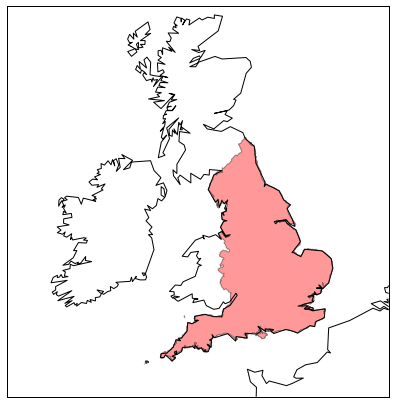

In [5]:
from matplotlib.patches import Polygon as PolygonMPL
from mpl_toolkits.basemap import Basemap

fig = figure(figsize=(14,7))
ax = fig.add_subplot(111, frame_on=False)
#mp = Basemap(projection='robin', lat_0=0, lon_0=0,
#              resolution='l', area_thresh=1000.0)
bm = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
    resolution='l', area_thresh = 1000.0,
    urcrnrlat=58.869587, urcrnrlon=4.186178,
    llcrnrlat=48.949979, llcrnrlon=-12.359231) # lat, lon

bm.drawcoastlines()
bm.drawmapboundary()
    
for cc in mp:
    xy = []
    for i in cc:
        xy.append(bm(i[0], i[1]))
    poly = PolygonMPL(xy, facecolor='red', alpha=0.4)
    plt.gca().add_patch(poly)

In [6]:
ukdocs = []
for d in docs:
    if mp.isInside(d['centre'][0], d['centre'][1]):
        ukdocs.append(d)
len(ukdocs)

87381

In [7]:
import pickle
    
with open('D:/ds/flooding/floods.pkl', 'rb') as file:
    alerts = pickle.load(file)

In [8]:
from datetime import timedelta, datetime

tmin = min([d['timestamp'] for d in ukdocs]) - timedelta(days=2) 
tmax = max([d['timestamp'] for d in ukdocs])

tmin, tmax

(datetime.datetime(2015, 12, 6, 16, 0, 0, 423000),
 datetime.datetime(2015, 12, 27, 7, 13, 26, 39000))

In [9]:
mnd = datetime(year=tmin.year, month=tmin.month, day=tmin.day)
mxd = datetime(year=tmax.year, month=tmax.month, day=18)

windows = {}

curdate = mnd
while curdate <= mxd:
    curdocs = []
    for d in alerts:
        if curdate <= d['starttime'] and curdate + timedelta(days=1) > d['starttime']:
            curdocs.append(d)
    windows[str(curdate)] = curdocs
    curdate += timedelta(days=1)
    print(str(curdate), "Alerts =", len(curdocs))
    
windows.keys()

2015-12-07 00:00:00 Alerts = 25
2015-12-08 00:00:00 Alerts = 3
2015-12-09 00:00:00 Alerts = 17
2015-12-10 00:00:00 Alerts = 26
2015-12-11 00:00:00 Alerts = 22
2015-12-12 00:00:00 Alerts = 7
2015-12-13 00:00:00 Alerts = 117
2015-12-14 00:00:00 Alerts = 8
2015-12-15 00:00:00 Alerts = 4
2015-12-16 00:00:00 Alerts = 3
2015-12-17 00:00:00 Alerts = 2
2015-12-18 00:00:00 Alerts = 1
2015-12-19 00:00:00 Alerts = 1


dict_keys(['2015-12-13 00:00:00', '2015-12-08 00:00:00', '2015-12-17 00:00:00', '2015-12-16 00:00:00', '2015-12-07 00:00:00', '2015-12-14 00:00:00', '2015-12-18 00:00:00', '2015-12-09 00:00:00', '2015-12-10 00:00:00', '2015-12-15 00:00:00', '2015-12-12 00:00:00', '2015-12-11 00:00:00', '2015-12-06 00:00:00'])

In [10]:
ukdocs[0]

{'_id': ObjectId('56ef00aeb654c419b4ab9047'),
 'area': 40.521555555555494,
 'centre': [-3.1358465378754947, 54.38226372361454],
 'gotpoly': True,
 'realgeo': None,
 'timestamp': datetime.datetime(2015, 12, 8, 16, 0, 0, 423000),
 'tweetid': ObjectId('5666fe7aed60b543ba43760d')}

In [11]:
from geopy.distance import vincenty

distances = []
for d in ukdocs:
    if d['timestamp'] > mxd:
        continue
    td = datetime(year=d['timestamp'].year, month=d['timestamp'].month, day=d['timestamp'].day)
    td2 = datetime(year=d['timestamp'].year, month=d['timestamp'].month, day=d['timestamp'].day - 1)
    warnings = windows[str(td)] + windows[str(td2)]
    
    mindis = min([vincenty(w['coordinates'], d['centre']).km for w in warnings])
    distances.append(mindis)

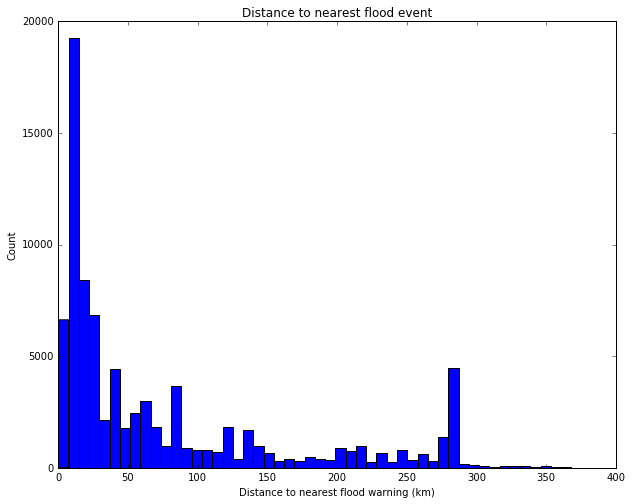

In [17]:
h = hist(distances, bins=50)
title('Distance to nearest flood event')
xlabel('Distance to nearest flood warning (km)')
ylabel('Count')
savefig('ukdocs.png', dpi=200, alpha=True)

In [13]:
import random
bb = mp.boundingBox() # xmin, ymin, xmax, ymax
def randpoint():
    return bb[0] + (random.random() * (bb[0] + bb[2])), bb[1] + (random.random() * (bb[1] + bb[3]))
   
distances_rand = []
for d in ukdocs:
    if d['timestamp'] > mxd:
        continue
    td = datetime(year=d['timestamp'].year, month=d['timestamp'].month, day=d['timestamp'].day)
    td2 = datetime(year=d['timestamp'].year, month=d['timestamp'].month, day=d['timestamp'].day - 1)
    warnings = windows[str(td)] + windows[str(td2)]
    
    point = randpoint()
    while not mp.isInside(point[0], point[1]):
        point = randpoint()
    
    mindis = min([vincenty(w['coordinates'], point).km for w in warnings])
    distances_rand.append(mindis)

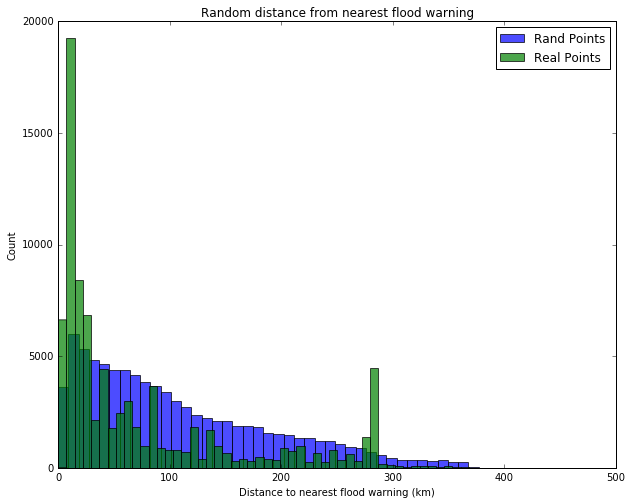

In [25]:
hist(distances_rand, bins=50, label='Rand Points', alpha=0.7)
hist(distances, bins=50, label='Real Points', alpha=0.7)
title('Random distance from nearest flood warning')
xlabel('Distance to nearest flood warning (km)')
ylabel('Count')
legend(loc=1)
savefig('ukdocs_rand_comp.png', dpi=200, alpha=True)

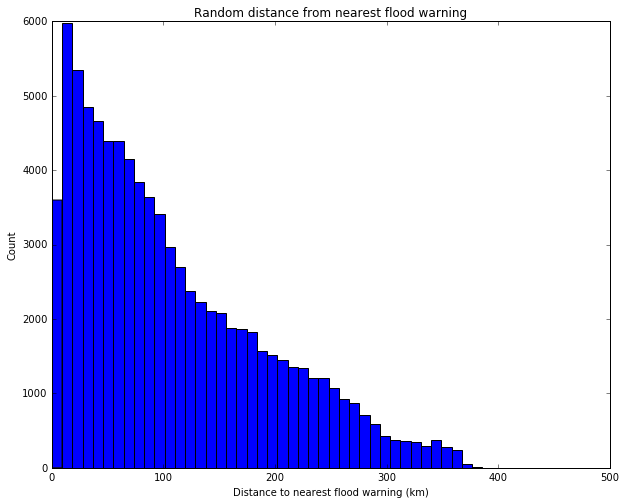

In [22]:
hist(distances_rand, bins=50, label='Rand Points')
title('Random distance from nearest flood warning')
xlabel('Distance to nearest flood warning (km)')
ylabel('Count')
savefig('rand_ukdocs.png', dpi=200, alpha=True)

In [24]:
distances_randsel = []
for d in ukdocs:
    if d['timestamp'] > mxd:
        continue
    td = datetime(year=d['timestamp'].year, month=d['timestamp'].month, day=d['timestamp'].day)
    td2 = datetime(year=d['timestamp'].year, month=d['timestamp'].month, day=d['timestamp'].day - 1)
    warnings = windows[str(td)] + windows[str(td2)]
    
    d2 = random.choice(ukdocs)
    
    mindis = min([vincenty(w['coordinates'], d2['centre']).km for w in warnings])
    distances_randsel.append(mindis)

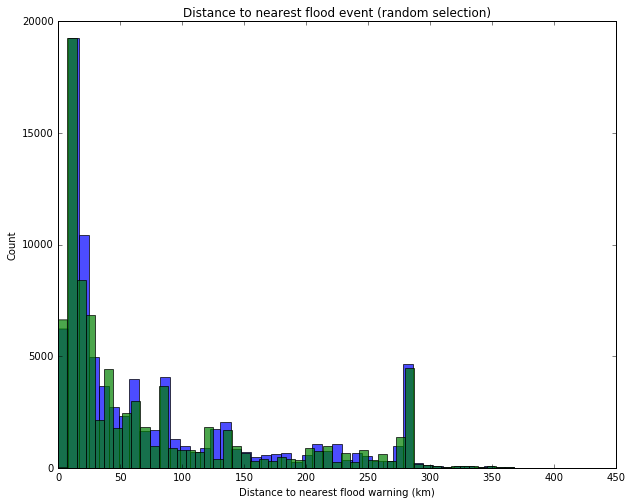

In [28]:
hist(distances_randsel, bins=50, alpha=0.7)
hist(distances, bins=50, label='Rand Points', alpha=0.7)
title('Distance to nearest flood event (random selection)')
xlabel('Distance to nearest flood warning (km)')
ylabel('Count')
savefig('ukdocs_randsel.png', dpi=200, alpha=True)

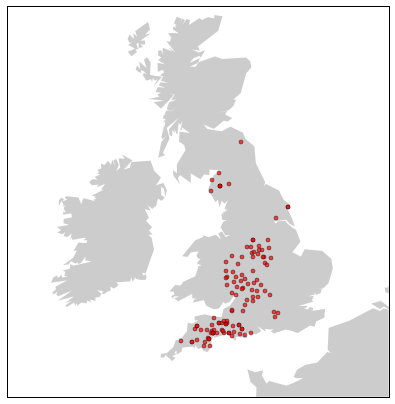

In [48]:
from mpl_toolkits.basemap import Basemap

fig = figure(figsize=(14,7))
mp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
    resolution='l', area_thresh = 1000.0,
    urcrnrlat=58.869587, urcrnrlon=4.186178,
    llcrnrlat=48.949979, llcrnrlon=-12.359231) # lat, lon


for x in alerts:
    if x['starttime'] < tmin +  timedelta(days=23) or x['starttime'] > tmin + timedelta(days=26) :
        continue
    try:
        x2,y = mp(x['coordinates'][0], x['coordinates'][1])
    except KeyError:
        continue
        
    mp.plot(x2, y, 'o', markersize=4, color='red', alpha=0.7)
        
#mp.drawcoastlines()
#mp.drawcountries()
mp.fillcontinents(color='#CCCCCC')#, zorder=0)
mp.drawmapboundary()

#plt.savefig('map-points-2.png', dpi=200, alpha=True)

In [50]:
tmin + timedelta(days=23), tmin + timedelta(days=26)

(datetime.datetime(2015, 12, 29, 16, 0, 0, 423000),
 datetime.datetime(2016, 1, 1, 16, 0, 0, 423000))

In [43]:
max([a['starttime'] for a in alerts])

datetime.datetime(2016, 1, 5, 0, 0)